In [2]:
from mppi import Utilities as U, Parsers as P
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import numpy as np
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
import yaml

# Plots

This notebook collects an extended analysis of the results of the RT computations.

## Analysis of the echo peaks 

We analyze the properties of the echo peaks in function of $\tau$.

This analysis is useful to assess the efficiency of the echo signal retrieval and to compare the numerical results with
the ones derived from the analytical perturbation theory

In [241]:
file = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/Results/echo_decay_int_1e3_2e2.yaml'
int_str = '1e3_2e2'

#file = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/Results/echo_decay_int_1e4_2e3.yaml'
#int_str = '1e4_2e3'

eta = 4e-1

In [242]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

We choose the values of $\tau$ reported in the plot and sorted in the correct order

In [243]:
tau = ['0.5ps','1ps','1.5ps','2ps','2.5ps']
echo_peak_vals = [1,2,3,4,5]

In [244]:
time = 1e-3*np.array(data_loaded['time'])
px_ref = np.array(data_loaded['px_ref'])
echo = data_loaded['echo']
profile = data_loaded['profile']

for t in tau:
    echo[t] = np.array(echo[t])
    profile[t] = np.array(profile[t])

We build the expected exponential decay of the polarization, starting from the its peak

In [245]:
ind_max = np.argmax(px_ref)
pol_peak = px_ref[ind_max]
time_exp = time[ind_max:]
exp_decay = pol_peak*np.exp(-eta*(time_exp-time_exp[0]))

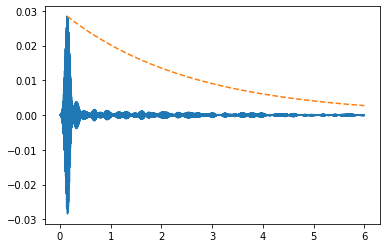

In [247]:
plt.plot(time,px_ref)
plt.plot(time_exp,exp_decay,linestyle='--')

In [248]:
time_exp[0],pol_peak

(0.14300000000000002, 0.0284330914)

We perform a gaussian fit of the first peak to estimate its properties

In [249]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [250]:
ind_max = argrelextrema(px_ref,np.greater,order=3)[0]
time_env = time[ind_max]
px_ref_env = px_ref[ind_max]

(0.0, 0.5)

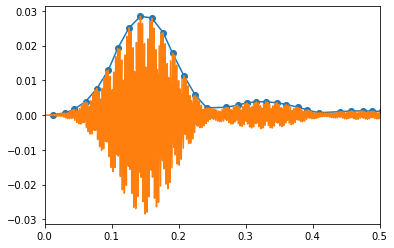

In [251]:
plt.plot(time_env,px_ref_env)
plt.scatter(time_env,px_ref_env)
plt.plot(time,px_ref)
plt.xlim(0,0.5)

In [252]:
ind_max = np.argmax(px_ref_env)
px_ref_env_max = px_ref_env[ind_max]
mean = time_env[ind_max]
ampl = px_ref_env_max
sigma = 0.04
p0 = [px_ref_env_max,mean,sigma]
gauss_pars_ref,pcov = curve_fit(gauss,time_env,px_ref_env,p0=p0)
p0,gauss_pars_ref

([0.0284330914, 0.14300000000000002, 0.04],
 array([0.0288505 , 0.14876859, 0.04326971]))

(0.0, 0.5)

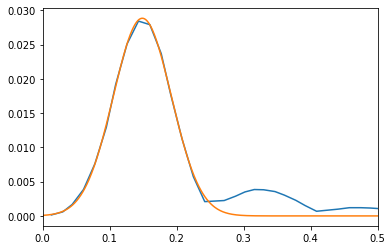

In [253]:
plt.plot(time_env,px_ref_env)
plt.plot(time,gauss(time,*gauss_pars_ref))
plt.xlim(0,0.5)

The width of the peak is the same of the profile of the pulse and the maximum is located at 149 fs, that is
around 20 fs after the peak of the profile.

We rescale the echo and the profile arrays, so that the maximum is set to 1

In [254]:
echo_max = max(echo[tau[0]])
profile_max = max(profile[tau[0]])
for t in tau:
    echo[t] = echo[t]/echo_max
    profile[t] = profile[t]/profile_max

We rescale the first peak of the profile for better plot visualization

In [255]:
ind_rescale = np.where(time > 0.4)[0][0]
rescale_profile = np.zeros([len(time)])
rescale_profile[:ind_rescale] = 1
rescale_profile[ind_rescale:] = 1
rescale_profile

array([1., 1., 1., ..., 1., 1., 1.])

We compute the maximum of the profile of the echo pulse

In [256]:
tmax_profile = {}
for t in tau:
    signal = profile[t]
    ind_max = argrelextrema(signal,np.greater,order=2)[0][1]
    tmax_profile[t] = time[ind_max]
tmax_profile

{'0.5ps': 0.629,
 '1ps': 1.127,
 '1.5ps': 1.629,
 '2ps': 2.1270000000000002,
 '2.5ps': 2.629}

In [257]:
times_profile = np.array([tmax_profile[i] for i in tau])
times_profile

array([0.629, 1.127, 1.629, 2.127, 2.629])

We define a procedure that perform a gaussian fit of the echo signal

In [258]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [259]:
gauss_pars = {}

for t,p in zip(tau,echo_peak_vals):
    signal = echo[t]
    # build the envelope of the signal
    ind_max = argrelextrema(signal,np.greater,order=3)[0]
    values_env = signal[ind_max]
    time_env = time[ind_max]
    # perform the fit
    mean = p
    sigma = 0.100
    popt,pcov = curve_fit(gauss,time_env,values_env,p0=[1,mean,sigma])
    gauss_pars[t] = popt
gauss_pars

{'0.5ps': array([0.98816126, 1.1289835 , 0.07979057]),
 '1ps': array([0.62001319, 2.12099248, 0.08726575]),
 '1.5ps': array([0.38027569, 3.12860226, 0.09169465]),
 '2ps': array([0.25464567, 4.11902559, 0.09216832]),
 '2.5ps': array([0.17695087, 5.12383984, 0.08713958])}

In [260]:
time_echo = np.array([gauss_pars[t][1] for t in tau])
theta_echo = echo_max*np.array([np.sqrt(2*np.pi)*gauss_pars[t][0]*gauss_pars[t][2] for t in tau]) # rescale times echo_max
time_echo

array([1.1289835 , 2.12099248, 3.12860226, 4.11902559, 5.12383984])

We can compute the distance between the max of the profile of the echo peak and the position of the max (according to a gaussian fit)
of the echo pulse

In [261]:
for t in tau:
    diffe = gauss_pars[t][1]-tmax_profile[t]
    print(t,diffe)

0.5ps 0.4999834974969286
1ps 0.9939924818189116
1.5ps 1.499602264397358
2ps 1.9920255872247004
2.5ps 2.494839836509741


This computation shows that the echo peak is realized as expected and the shift w.r.t. the nominal time is due to the finite
size of the pulse

We fit the echo areas with a simple exponential decay and compute the echo efficiency 
$$
\theta_{echo}(t) = \theta_{ref}\lambda e^{-\eta(t-t_0)}
$$
where $\lambda$ is the efficiency of the echo retrieval and $t_0$ is the time position of the first peak

In [262]:
theta_ref = np.sqrt(2*np.pi)*gauss_pars_ref[0]*gauss_pars_ref[2]
t0 = gauss_pars_ref[1]

In [263]:
def monoExp(t, l):
    return theta_ref*l*np.exp(-eta*(t-t0))

In [264]:
l0 = 1e-2 # start with values near those we expect
params, cv = curve_fit(monoExp, time_echo, theta_echo, l0)
l = params[0]
l

0.017855891372257147

508.8799234126034


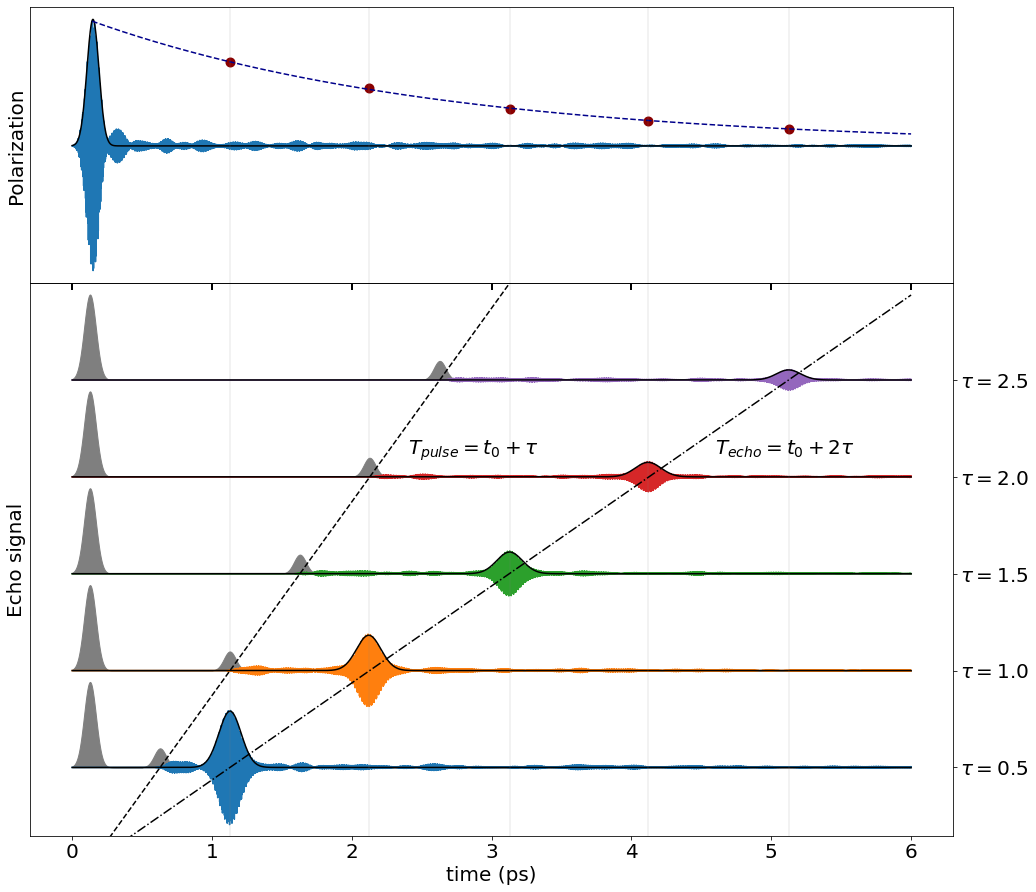

In [266]:
tau_disp = [r'$\tau=0.5$',r'$\tau=1.0$',r'$\tau=1.5$',r'$\tau=2.0$',r'$\tau=2.5$']
label_size = 20
e_min = -1.2
e_max = 8.5
shift = 1.7
a_profile = 4*shift/(times_profile[-1]-times_profile[0])
b_profile = -a_profile*times_profile[0]
a_echo = 4*shift/(times_echo[-1]-times_echo[0])
b_echo = -a_echo*times_echo[0]
scatter_rescale = max(px_ref)/(theta_ref*l)
print(scatter_rescale)

ypos=0

fig, ax1 = plt.subplots(figsize=(14, 12))
gs = gridspec.GridSpec(2, 1, height_ratios=[1,2]) 
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[0])

for t in tau:
    ax1.plot(time,ypos+echo[t]) #,color='tab:orange'
    ax1.fill_between(time,ypos+1.5*profile[t]*rescale_profile,ypos,color='tab:grey')
    ax1.plot(time,ypos+gauss(time,*gauss_pars[t]),color='black',linestyle='-')
    ax1.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
    ypos+=shift
ax1.plot(time,a_profile*time+b_profile,color='black',linestyle='--')
ax1.plot(time,a_echo*time+b_echo,color='black',linestyle='-.')

ax1.text(2.4,5.5,'$T_{pulse}=t_0+\\tau$',size=label_size)
ax1.text(4.6,5.5,'$T_{echo}=t_0+2\\tau$',size=label_size)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('Echo signal',size=label_size)
ax1.set_ylim(e_min,e_max)
ax1.set_yticks([shift*i for i in range(len(tau_disp))])
ax1.set_yticklabels(tau_disp,size=label_size)
ax1.yaxis.tick_right()
ax1.tick_params(axis='both', which='major', labelsize=label_size)

ax2.scatter(time_echo,scatter_rescale*theta_echo,linewidth=4,color='darkred')
ax2.plot(time,px_ref)
ax2.plot(time,gauss(time,*gauss_pars_ref),color='black',linestyle='-')
ax2.plot(time_exp,exp_decay,linestyle='--',color='darkblue')
for t in tau:
    ax2.axvline(gauss_pars[t][1],color='grey',linestyle='-',linewidth=0.2)
#ax2.axhline(0,color='black',linestyle='-')
#ax2.set_xticks([])
ax2.set_xticks([0,1,2,3,4,5,6])
ax2.set_xticklabels([])
ax2.set_yticks([])
ax2.tick_params(width=2,length=7)
ax2.set_ylabel('Polarization',size=label_size)

plt.tight_layout(pad=-0.7)

#plt.savefig(fname='Plot/echo_analysis_%s.eps'%int_str,format='eps',bbox_inches = "tight")

where $t_0$=129 fs.

In [267]:
# the shape is consistent with a delay 2*tau
a_echo/a_profile

0.500643785476959

In [ ]:
#################################################################################

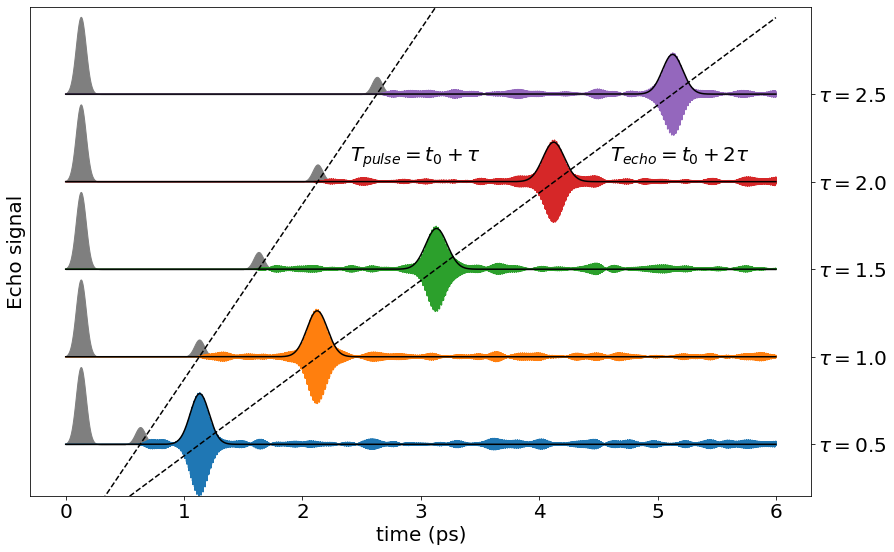

In [54]:
tau_disp = [r'$\tau=0.5$',r'$\tau=1.0$',r'$\tau=1.5$',r'$\tau=2.0$',r'$\tau=2.5$']
label_size = 20
e_min = -1
e_max = 8.5
shift = 1.7
a_profile = 4*shift/(times_profile[-1]-times_profile[0])
b_profile = -a_profile*times_profile[0]
a_echo = 4*shift/(times_echo[-1]-times_echo[0])
b_echo = -a_echo*times_echo[0]

ypos=0

fig, ax1 = plt.subplots(figsize=(14, 9))

for t in tau:
    ax1.plot(time,ypos+echo[t]) #,color='tab:orange'
    ax1.fill_between(time,ypos+1.5*profile[t]*rescale_profile,ypos,color='tab:grey')
    ax1.plot(time,ypos+gauss(time,*gauss_pars[t]),color='black',linestyle='-')
    ypos+=shift
ax1.plot(time,a_profile*time+b_profile,color='black',linestyle='--')
ax1.plot(time,a_echo*time+b_echo,color='black',linestyle='--')

ax1.text(2.4,5.5,'$T_{pulse}=t_0+\\tau$',size=label_size)
ax1.text(4.6,5.5,'$T_{echo}=t_0+2\\tau$',size=label_size)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('Echo signal',size=label_size)
ax1.set_ylim(e_min,e_max)
ax1.set_yticks([shift*i for i in range(len(tau_disp))])
ax1.set_yticklabels(tau_disp,size=label_size)
ax1.yaxis.tick_right()
ax1.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/echo_analysis_%s.eps'%int_str,format='eps',bbox_inches = "tight")

Lastly we compute the ratio between the area of the first peak and the areas of the echo peaks.
We use the gaussian fit to compute the areas

In [227]:
signal = ref
# build the envelope of the signal
ind_max = argrelextrema(signal,np.greater,order=2)[0]
values_env = signal[ind_max]
time_env = time[ind_max]
# perform the fit
mean = 130
sigma = 100
gauss_pars_ref,pcov = curve_fit(gaus,time_env,values_env,p0=[1,mean,sigma])
gauss_pars_ref

array([2.64497706e-02, 1.49103954e+02, 4.37069522e+01])

In [229]:
def theta(pars):
    return np.sqrt(2*np.pi)*pars[0]*pars[2]

In [234]:
area_ref = theta(gauss_pars_ref)
print('area ref',area_ref)
for t in tau:
    area = echo_max*theta(gauss_pars[t])
    ratio = area/theta_ref
    print(t,area,ratio)

area ref 2.8977596965451995
0.5ps 0.024996534808109542 0.00862615862796049
1ps 0.024091165618192974 0.008313720991742421
1.5ps 0.022739875433066496 0.00784739861630959
2ps 0.02196878564846379 0.007581300021066505
2.5ps 0.02102110952751481 0.007254262509267707


the ratio is about 8e-3 and decrease in function of $\tau$. Maybe is due to the small dephasing included in the
computation? To be checked....

We observe that the width of the first peak is about 44 ps (comparable with the one of the pulse
of about 42 ps), while the echo peaks are broader, with widths between 80 and 90 ps

## Decay constant from the echo peaks

We measure the physical dephasing time from the height and time position of the echo peaks.

In [3]:
file = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/Results/echo_decay_int_1e3_2e2.yaml'
int_str = '1e3_2e2'

#file = 'RT_Echo_k509-activated-energy_1.46-width_0.025/FixSymm/Results/echo_decay_int_1e4_2e3.yaml'
#int_str = '1e4_2e3'

eta = 4e-4*1e3 # in ps^-1

In [4]:
eta

0.4

In [3]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'px_ref', 'time'])

In [4]:
time = 1e-3*np.array(data_loaded['time']) # in ps
px_ref = np.array(data_loaded['px_ref'])
echo = data_loaded['echo']
profile = data_loaded['profile']

for tau in echo:
    echo[tau] = np.array(echo[tau])
    profile[tau] = np.array(profile[tau])

In [5]:
echo.keys()

dict_keys(['0.5ps', '1.5ps', '1ps', '2.5ps', '2ps'])

We show some features of the profile of the pulse

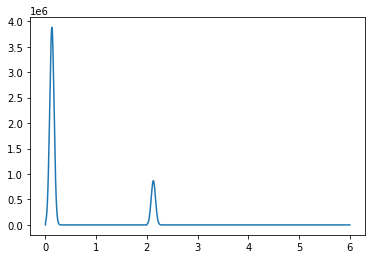

In [6]:
signal = profile['2ps']
plt.plot(time,signal)

In [7]:
ind_max = argrelextrema(signal,np.greater,order=2)[0]
time[ind_max]

array([0.127, 2.127])

The first peak is at t=127 fs and the second one is $\tau$ fs later, as expected.

We build the expected exponential decay of the polarization, starting from the its peak

In [8]:
ind_max = np.argmax(px_ref)
pol_peak = px_ref[ind_max]
time_exp = time[ind_max:]
exp_decay = pol_peak*np.exp(-eta*(time_exp-time_exp[0]))

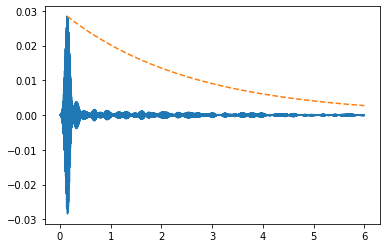

In [9]:
plt.plot(time,px_ref)
plt.plot(time_exp,exp_decay,linestyle='--')

In [10]:
time_exp[0],pol_peak

(0.14300000000000002, 0.0284330914)

We perform a gaussian fit of the first peak to estimate its properties

In [11]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [12]:
ind_max = argrelextrema(px_ref,np.greater,order=3)[0]
time_env = time[ind_max]
px_ref_env = px_ref[ind_max]

(0.0, 0.5)

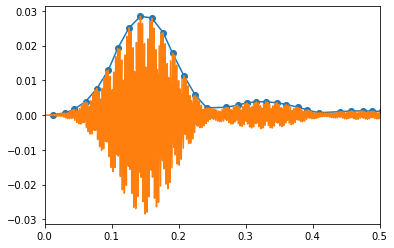

In [13]:
plt.plot(time_env,px_ref_env)
plt.scatter(time_env,px_ref_env)
plt.plot(time,px_ref)
plt.xlim(0,0.5)

In [14]:
ind_max = np.argmax(px_ref_env)
px_ref_env_max = px_ref_env[ind_max]
mean = time_env[ind_max]
ampl = px_ref_env_max
sigma = 0.04
p0 = [px_ref_env_max,mean,sigma]
gauss_pars_ref,pcov = curve_fit(gauss,time_env,px_ref_env,p0=p0)
p0,gauss_pars_ref

([0.0284330914, 0.14300000000000002, 0.04],
 array([0.0288505 , 0.14876859, 0.04326971]))

(0.0, 0.5)

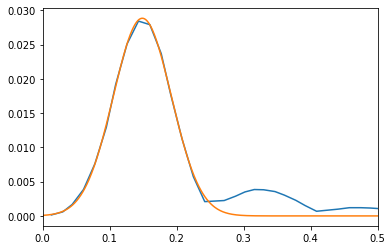

In [15]:
plt.plot(time_env,px_ref_env)
plt.plot(time,gauss(time,*gauss_pars_ref))
plt.xlim(0,0.5)

The width of the peak is the same of the profile of the pulse and the maximum is located at 149 fs, that is
around 20 fs after the peak of the profile.

We perform a gaussian fit of the envelope profiles of the echo peaks and we fit the areas of the gaussians with a single exponential decay

In [16]:
tau = ['0.5ps','1ps','1.5ps','2ps','2.5ps']

In [17]:
gauss_pars = {}
for t in tau:
    ind_rel_max = argrelextrema(echo[t],np.greater,order=3)[0]
    time_env = time[ind_rel_max]
    echo_env = echo[t][ind_rel_max]
    ind_max = np.argmax(echo_env)
    mean = time_env[ind_max]
    ampl = echo_env[ind_max]
    sigma = 0.1
    p0 = [ampl,mean,sigma]
    popt,pcov = curve_fit(gauss,time_env,echo_env,p0=p0)
    gauss_pars[t]  = popt
gauss_pars

{'0.5ps': array([1.88407806e-04, 1.12898349e+00, 7.97905426e-02]),
 '1ps': array([1.18214932e-04, 2.12099247e+00, 8.72655830e-02]),
 '1.5ps': array([7.25051541e-05, 3.12860230e+00, 9.16949381e-02]),
 '2ps': array([4.85521915e-05, 4.11902564e+00, 9.21676567e-02]),
 '2.5ps': array([3.37383203e-05, 5.12383982e+00, 8.71396797e-02])}

In [19]:
theta_ref = np.sqrt(2*np.pi)*gauss_pars_ref[0]*gauss_pars_ref[2]
theta_ref

0.0031291560996598833

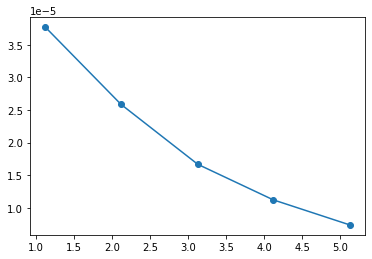

In [20]:
theta_echo = []
time_echo = []
for t in tau:
    theta_echo.append(np.sqrt(2*np.pi)*gauss_pars[t][0]*gauss_pars[t][2])
    time_echo.append(gauss_pars[t][1])
theta_echo = np.array(theta_echo)
time_echo = np.array(time_echo)
plt.plot(time_echo,theta_echo)
plt.scatter(time_echo,theta_echo)

We fit this curve as
$$
\theta_{echo}(t) = \theta_{ref}\lambda e^{-\eta t}
$$
where $\lambda$ is the efficiency of the echo retrieval

In [21]:
def monoExp(t, l):
    return theta_ref*l*np.exp(-eta*t)

In [23]:
l0 = 1e-2 # start with values near those we expect
params, cv = curve_fit(monoExp, time_echo, theta_echo, l0)
l = params[0]
l

0.018950694930921594

In [24]:
exp_fit = monoExp(time,l)

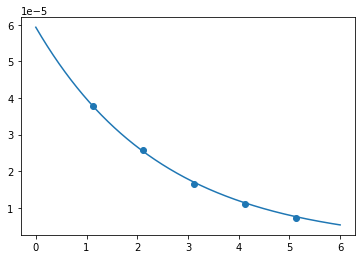

In [25]:
plt.scatter(time_echo,theta_echo)
plt.plot(time,exp_fit)

We observe that the theta_echo variable follows an exponential decay with the expected value of $\eta$.

On the basis of this analysis the efficiency of the echo retrieval associated to this choice of pulse 
intensity is equal tox0 (which represents the ratio between the area of the echo peak and the area of the reference 
peak extrapolated at $t=0$)

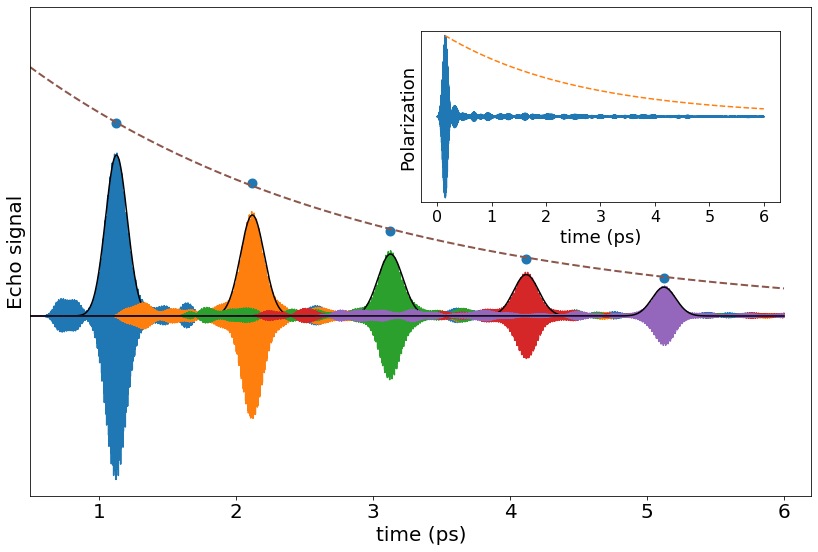

In [27]:
label_size = 20
label_size_inset = 18
e_min = min(echo['0.5ps'])*1.1
e_max = max(echo['0.5ps'])*1.9
rescale1 = 1.2*gauss_pars['0.5ps'][0]/theta_echo[0]
rescale2 = gauss_pars_ref[0]/(theta_echo[0]*np.exp(eta*time_echo[0])) 

fig, ax1 = plt.subplots(figsize=(14, 9))

for t in tau:
    ax1.plot(time,echo[t])
    ax1.plot(time,gauss(time,*gauss_pars[t]),color='black',linestyle='-')
ax1.scatter(time_echo,rescale1*theta_echo,linewidth=4)
ax1.plot(time,rescale1*exp_fit,linestyle='--',linewidth=2)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('Echo signal',size=label_size)
ax1.set_xlim(0.5,6.2)
ax1.set_ylim(e_min,e_max)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.5,0.6,0.46,0.35])
ax2.set_axes_locator(ip)
ax2.plot(time,px_ref)
ax2.plot(time_exp,exp_decay,linestyle='--')
#ax2.scatter(time_echo,rescale2*theta_echo,linewidth=4)
ax2.set_yticks([])
ax2.set_ylim(-0.03,0.03)
ax2.set_xlabel('time (ps)',size=label_size_inset)
ax2.set_ylabel('Polarization',size=label_size_inset)
ax2.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(fname='Plot/echo_decay_%s.eps'%int_str,format='eps',bbox_inches = "tight")

The same data can be rendered as

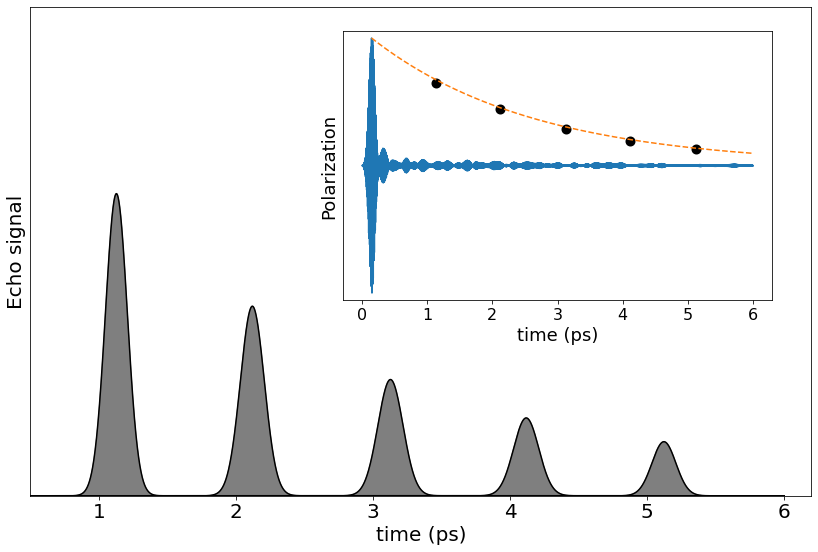

In [28]:
label_size = 20
label_size_inset = 18
e_min = 0 #-5e-5
e_max = max(echo['0.5ps'])*1.6
rescale1 = gauss_pars['0.5ps'][0]/theta_echo[0]
rescale2 = gauss_pars_ref[0]/(theta_echo[0]*np.exp(eta*time_echo[0])) 

fig, ax1 = plt.subplots(figsize=(14, 9))

for t in tau:
    #ax1.plot(time,echo[t])
    ax1.plot(time,gauss(time,*gauss_pars[t]),color='black',linestyle='-')
    ax1.fill_between(time,gauss(time,*gauss_pars[t]),0,color='tab:grey')
#ax1.scatter(time_ratio,rescale1*area_ratio,linewidth=4)
#ax1.plot(time,rescale1*exp_fit,linestyle='--',linewidth=2)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('Echo signal',size=label_size)
ax1.set_xlim(0.5,6.2)
ax1.set_ylim(e_min,e_max)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.4,0.4,0.55,0.55])
ax2.set_axes_locator(ip)
ax2.plot(time,px_ref)
ax2.plot(time_exp,exp_decay,linestyle='--')
ax2.scatter(time_echo,rescale2*theta_echo,linewidth=4,color='black')
ax2.set_yticks([])
ax2.set_ylim(-0.03,0.03)
ax2.set_xlabel('time (ps)',size=label_size_inset)
ax2.set_ylabel('Polarization',size=label_size_inset)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='Plot/echo_decay_%s.eps'%int_str,format='eps',bbox_inches = "tight")